In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['highway','insidecity','tallbuilding','street','forest','coast','mountain','opencountry'])
folder = "./LabelMe/"

### Load Data and preprocess

In [4]:
X_train_vgg16 = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

X_val_vgg16 = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

X_test_vgg16 = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",X_train_vgg16.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


In [5]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [6]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

(1000, 512)

### Load annotations / Generate

In [6]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


In [8]:
#change annnotations..
10000/59

169.4915254237288

In [7]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

(1000, 2547)

In [27]:
#perturbe annotations by annotators
total_annotations = T_weights.sum(axis=0)

new_annotations = np.ones((N, 20000),dtype='int16')*-1
new_annotations[:,:T] = y_obs

for new_t in range(T,new_annotations.shape[1]):
    t_select = np.random.randint(T)
    
    t_aux = np.random.poisson(10) #1 #values left-- change value to remove few annotators
    mask_bin = (np.random.multinomial(t_aux, np.tile(1./N,N)) != 0)
    
    new_annotator = mask_bin*(y_obs[:,t_select]+1) -1 #new annotations of annotator generated
    new_annotations[:,new_t] = new_annotator
    
T_weights = np.sum(new_annotations != -1,axis=0) #distribucion de anotaciones
print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
new_annotations = new_annotations[:,T_weights!=0]
new_annotations.shape

Remove 13928 annotators that do not annotate on this set 


(1000, 6072)

In [30]:
np.savetxt(folder+"answers_v3.txt",new_annotations, delimiter=",", fmt="%i")

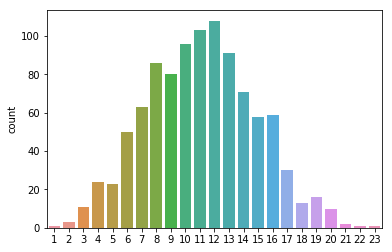

Minimum annotations in a example:  1
Maximum annotations in a example:  23
T data (expected value):  11.115
Graphics of T weights


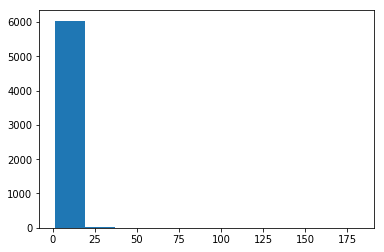

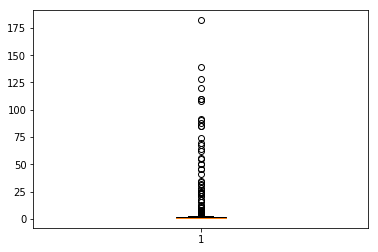

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  182
Mean annotations by an annotator:  1.8305335968379446


In [28]:
T_weights = np.sum(new_annotations != -1,axis=0) #distribucion de anotaciones

N_ann = np.sum(new_annotations != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

In [ ]:
y_obs = new_annotations.copy() 
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

y_obs.shape

In [7]:
#generate conf matrix...
confe_matrix = np.zeros((T,K,K),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix[t,:,:][~mask_nan],axis=0)
    for value in np.arange(K)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix[t,:,:] = confe_matrix[t,:,:]/confe_matrix[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix

array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.125     , 0.125     , 0.125     , ..., 0.125     ,
         0.125     , 0.125     ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

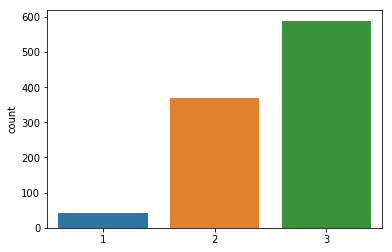

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


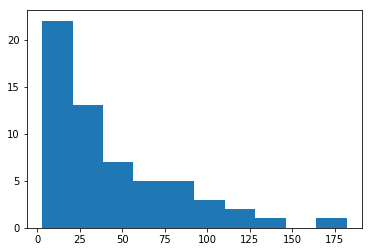

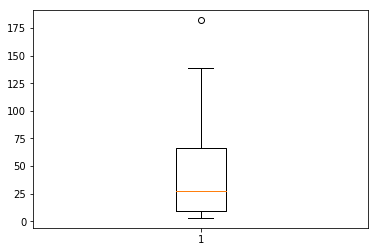

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182


In [8]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())

#### Delta Convergence criteria

In [8]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [13]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 14


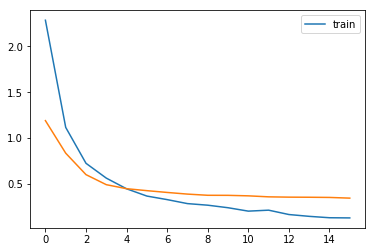

In [46]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [9]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas = label_I.mv_labels('probas')
mv_onehot = label_I.mv_labels('onehot')

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -2837.162200875911
2 	 -2760.563766478105 	0.0216	0.166209	0.026998
3 	 -2734.590813874461 	0.0124	0.062463	0.009409
4 	 -2723.3804007886947 	0.0073	0.061532	0.004099
5 	 -2717.719492056542 	0.0045	0.054811	0.002079
6 	 -2714.5174744019014 	0.0031	0.043390	0.001178
7 	 -2712.672939758045 	0.0022	0.033013	0.000680
8 	 -2711.508833755188 	0.0017	0.026319	0.000429
Class marginals
[0.08 0.11 0.14 0.11 0.14 0.14 0.17 0.09]


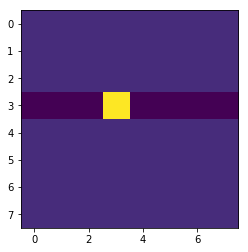

In [40]:
plt.imshow(confe_matrix[0])

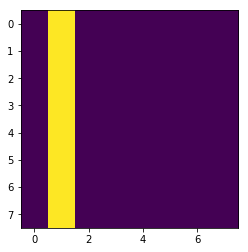

In [17]:
plt.imshow(ds_conf[3])

In [11]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


In [24]:
#check ds with  theones come with data
aux = np.loadtxt("./LabelMe/answers_DS.txt",dtype='int')
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train)) #calculated by Rodrigues (until converge)
print("Similaririty between ours and his: ",np.mean(ds_labels.argmax(axis=1) == aux))

ACC D&S on train: 0.804
Similaririty between ours and his:  0.966


In [48]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 8


In [50]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 16


In [15]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 6


### Raykar Model (joint predict model)

In [12]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1000, 59, 8)


In [17]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2547, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 1.36 sec)	logL: -4404.393	
Iter 2/50 
M step: done,  E step: done //  (in 0.24 sec)	logL: -4206.977	Tol1: 0.04482	Tol2: 0.01334	
Iter 3/50 
M step: done,  E step: done //  (in 0.31 sec)	logL: -4126.872	Tol1: 0.01904	Tol2: 0.00512	
Finished training
Initializing new EM...
Betas shape:  (2547, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.81 sec)	logL: -4525.334	
Iter 2/50 
M step: done,  E step: done //  (in 0.20 sec)	logL: -4274.862	Tol1: 0.05535	Tol2: 0.01659	
Iter 3/50 
M step: done,  E step: done //  (in 0.17 sec)	logL: -4178.549	Tol1: 0.02253	Tol2: 0.00597	
Finished training
Initializing new EM...
Betas shape:  (2547, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.82 sec)	logL: -4374.551	
Iter 2/50 
M step: done,  E step: done //  (in 0.23 sec)	

In [21]:
Z_train_p = raykarMC.base_model.predict(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)

Bayesian gaussian mixture say is 20 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt

DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters
Annotators PCA of annotations shape:  (5197, 4)


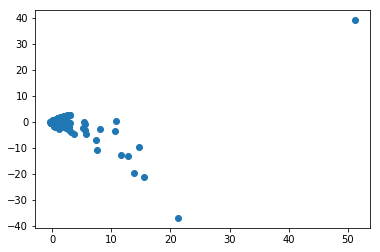

In [12]:
## cluster annotations?
from sklearn.preprocessing import StandardScaler
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

### Our Proposed

In [10]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 2 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
shape: (1000, 8)


Normalized entropy (0-1) of repeats annotations: 0.11212816116784208


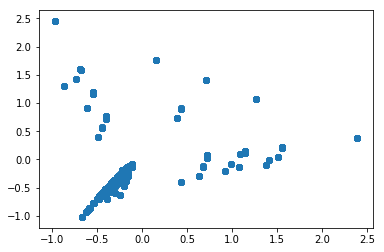

In [14]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

In [12]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
        gMixture_Global.lambda_random = True 
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.004291 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.75850636]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -3188.332	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2258.806	Tol1: 0.29154	Tol2: 0.50853	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1990.818	Tol1: 0.11864	Tol2: 0.19193	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1857.084	Tol1: 0.06718	Tol2: 0.12246	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1774.790	Tol1: 0.04431	Tol2: 0.08538	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1716.540	Tol1: 0.03282	Tol2: 0.07613	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1671.100	Tol1: 0.

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.005241 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01042711]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -3707.898	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2305.808	Tol1: 0.37814	Tol2: 2.18094	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1975.891	Tol1: 0.14308	Tol2: 0.28930	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1839.411	Tol1: 0.06907	Tol2: 0.16791	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1754.975	Tol1: 0.04590	Tol2: 0.10002	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1702.162	Tol1: 0.03009	Tol2: 0.06337	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1654.064	Tol1: 0.

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.005396 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7649964  0.35427967 0.05306005 0.08938941 0.32689986]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.57 sec)	logL: -7404.934	
Finished training!


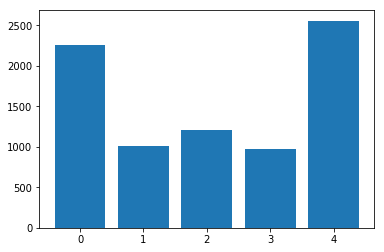

<BarContainer object of 5 artists>

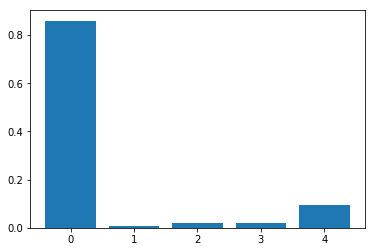

In [16]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL
                               ,cluster=True)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

/users/fmena/MixtureofGroups/code/utils.py:285: RuntimeWarning: invalid value encountered in true_divide
  entropy_values = [entropy(value)/np.log(len(value)) for value in probas_Mchange]


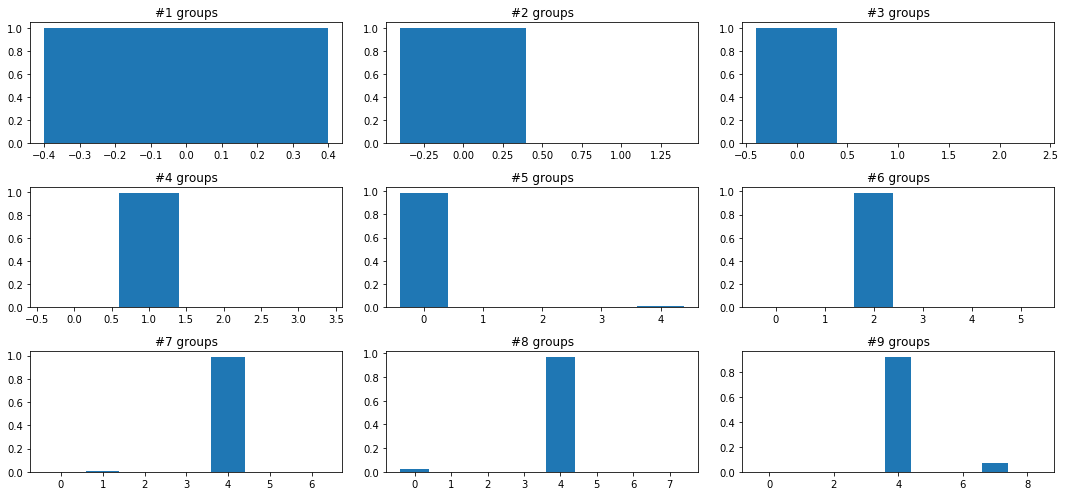

<Figure size 1080x360 with 0 Axes>

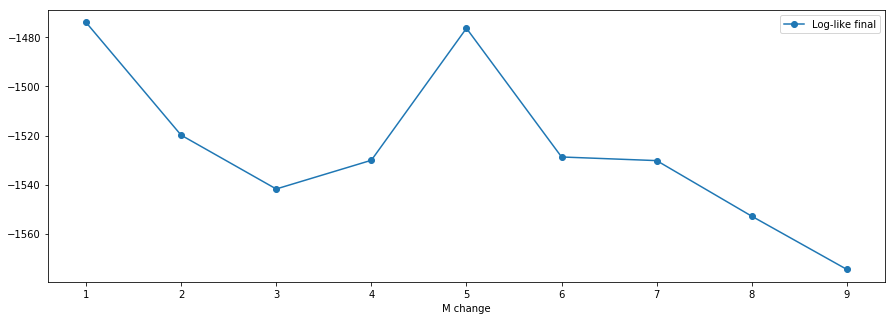

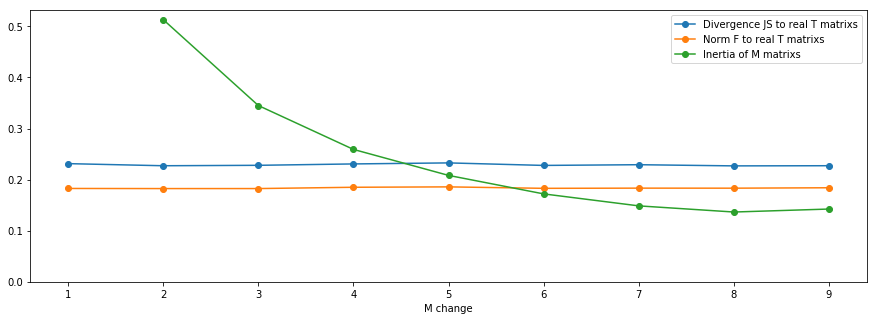

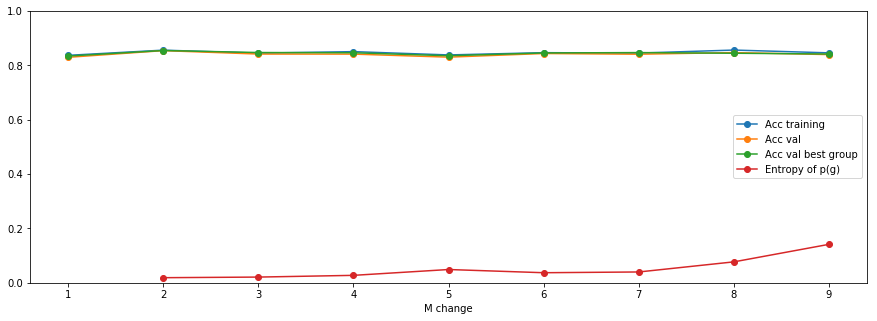

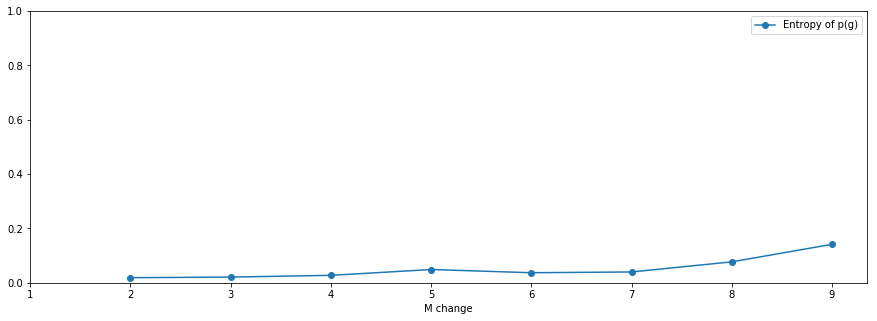

In [13]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [17]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

59


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0        1              1              1                   1   
1        2              1              1                   1   
2        3              1              1                   1   
3        4              2              1                   1   
4        5              1              1                   1   
5        6              1              1                   1   
6        7              2              1                   1   
7        8              2              2                   1   
8        9              2              1                   1   

   Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                1                                1  
1                                1                                1  
2                                1                                1  
3                                2                                1  
4                                1                                1  
5                                1                                1  
6                                2                                1  
7                                2                                2  
8                                2                                1

1, 2 o 3...

In [11]:
M_seted = 3 #??

In [24]:
imp = 0.1
r_obs.sum(axis=-1).sum(axis=-1)/M_seted #to get a uniform groups...

849.0

In [25]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)

gMixture_Global.define_priors("laplace")
gMixture_Global.define_priors(np.tile(849*imp,gMixture_Global.M)) #revisra sin esto queda con prior de 1...

gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.001870 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.52 0.22 0.95]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -2811.978	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2060.550	Tol1: 0.26722	Tol2: 0.28814	Tol3: 0.30205	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1890.468	Tol1: 0.08254	Tol2: 0.19244	Tol3: 0.06409	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1805.284	Tol1: 0.04506	Tol2: 0.11249	Tol3: 0.07535	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1752.500	Tol1: 0.02924	Tol2: 0.08533	Tol3: 0.06927	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1724.381	Tol1: 0.01605	Tol2: 0.07328	Tol3: 0.06454	
Iter 7/50
M step: done,  E step: done //  (in 0.05 

In [26]:
Z_train_p = gMixture_Global.base_model.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.base_model.predict(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

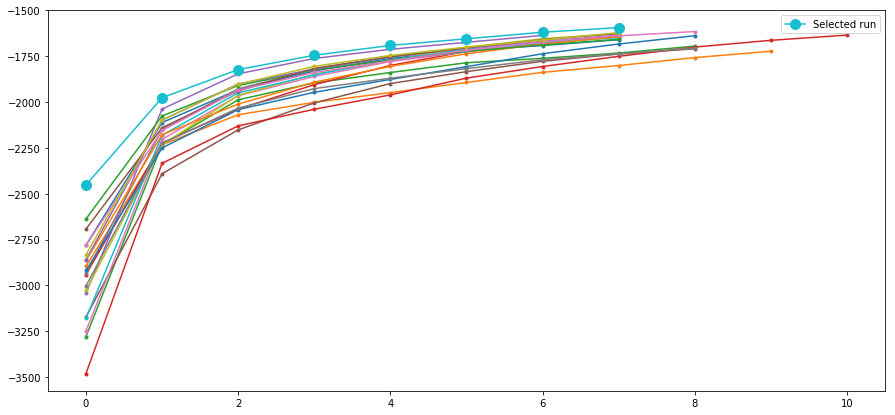

In [16]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [15]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [101]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global       0.979         0.979
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.920875      0.920875
====  ======  ==========  ============


*** Soft-Majority (Train with softMV) ***
Train


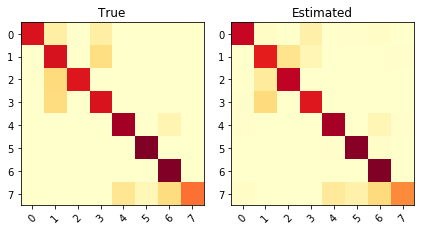

JS divergence: 0.0268	Norm Frobenius: 0.0381


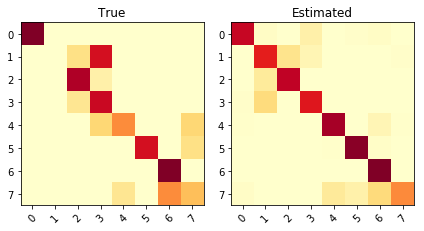

JS divergence: 0.1973	Norm Frobenius: 0.1640


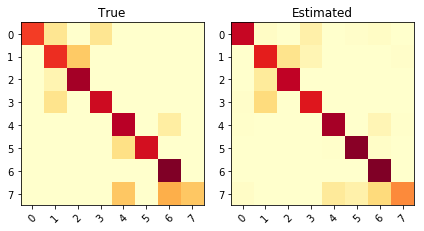

JS divergence: 0.0448	Norm Frobenius: 0.0640


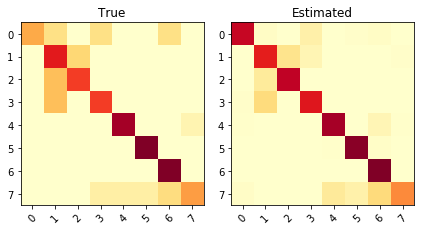

JS divergence: 0.0537	Norm Frobenius: 0.0794


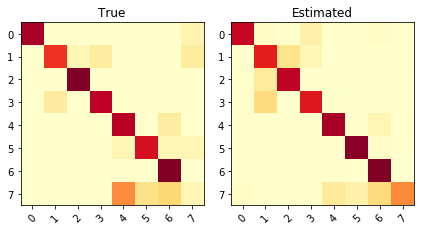

JS divergence: 0.0759	Norm Frobenius: 0.0880


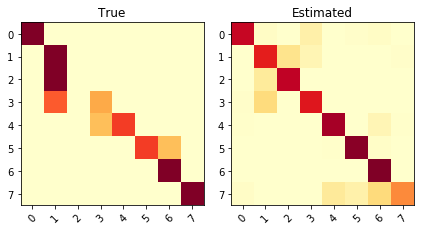

JS divergence: 0.2144	Norm Frobenius: 0.2018


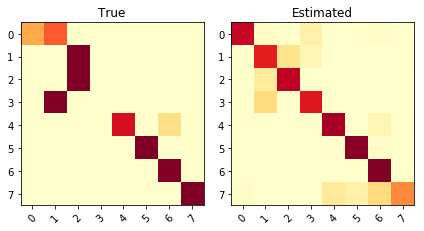

JS divergence: 0.2505	Norm Frobenius: 0.2286


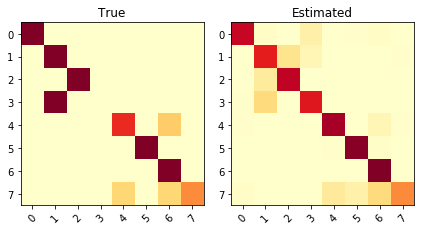

JS divergence: 0.1283	Norm Frobenius: 0.1517


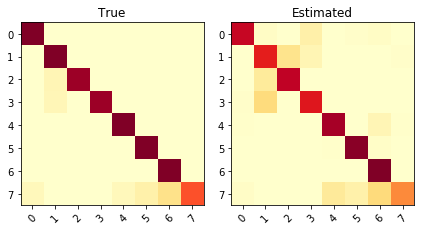

JS divergence: 0.0460	Norm Frobenius: 0.0622


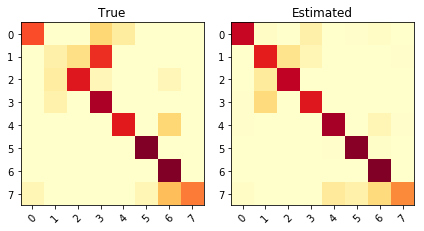

JS divergence: 0.0995	Norm Frobenius: 0.1282


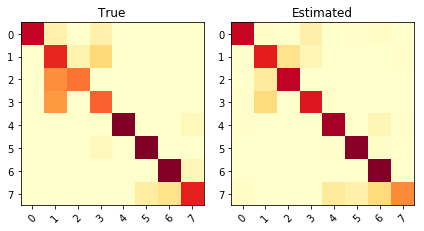

JS divergence: 0.0541	Norm Frobenius: 0.0826


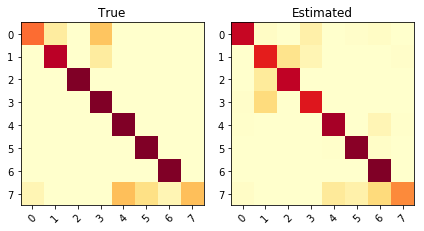

JS divergence: 0.0706	Norm Frobenius: 0.0840


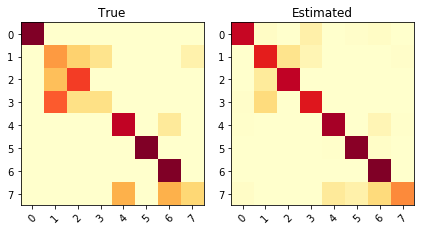

JS divergence: 0.0835	Norm Frobenius: 0.1173


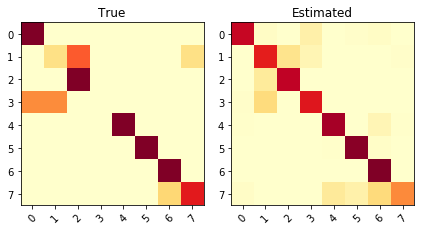

JS divergence: 0.1643	Norm Frobenius: 0.1573


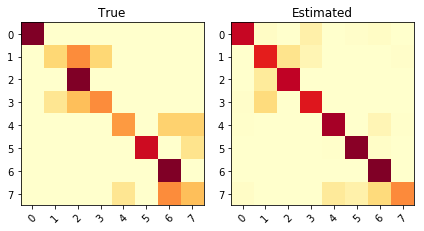

JS divergence: 0.1230	Norm Frobenius: 0.1332
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global       0.822         0.822      0.170935     0.2158       0.115817    0.107925
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.765993      0.765993
====  ======  ==========  ============


In [49]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


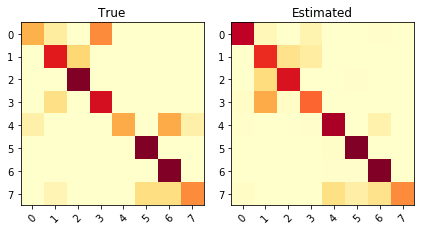

JS divergence: 0.1083	Norm Frobenius: 0.1280


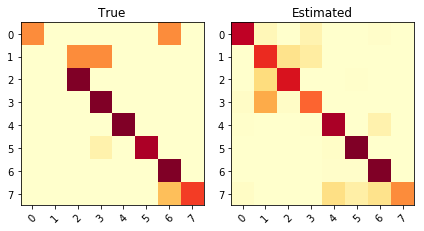

JS divergence: 0.1871	Norm Frobenius: 0.1621


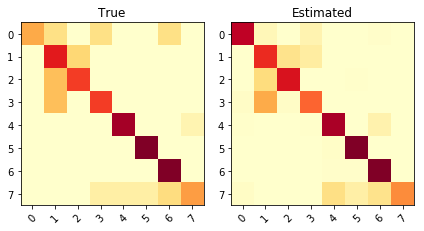

JS divergence: 0.0587	Norm Frobenius: 0.0766


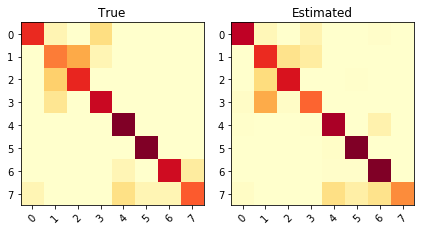

JS divergence: 0.0426	Norm Frobenius: 0.0724


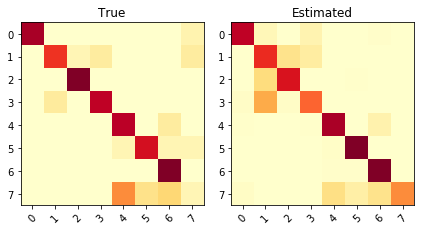

JS divergence: 0.0904	Norm Frobenius: 0.1000


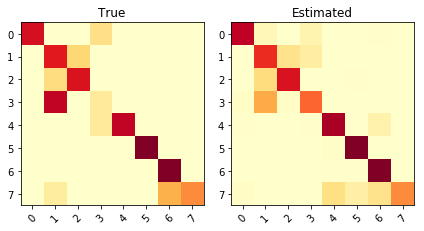

JS divergence: 0.0840	Norm Frobenius: 0.0951


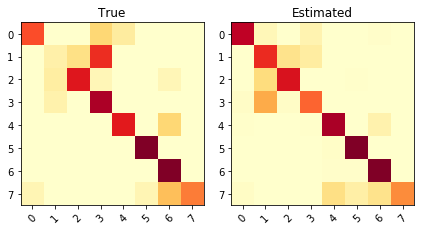

JS divergence: 0.1086	Norm Frobenius: 0.1331


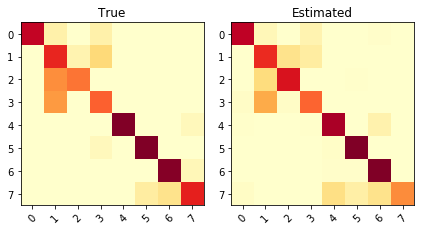

JS divergence: 0.0468	Norm Frobenius: 0.0636


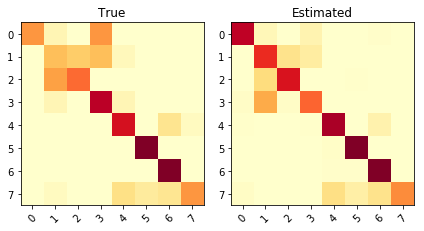

JS divergence: 0.0705	Norm Frobenius: 0.1123


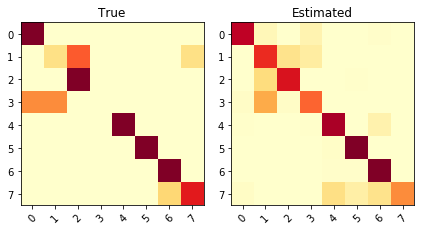

JS divergence: 0.1637	Norm Frobenius: 0.1438


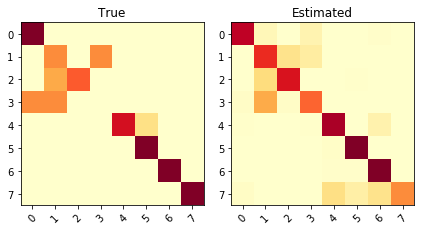

JS divergence: 0.1609	Norm Frobenius: 0.1414


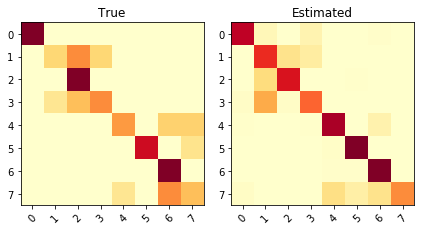

JS divergence: 0.1248	Norm Frobenius: 0.1319


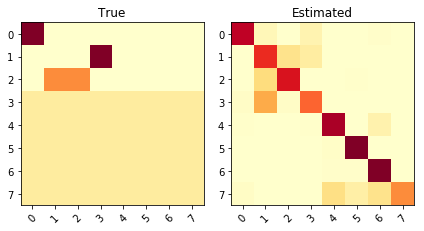

JS divergence: 0.4500	Norm Frobenius: 0.2626


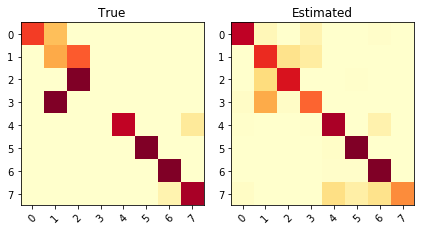

JS divergence: 0.1496	Norm Frobenius: 0.1515


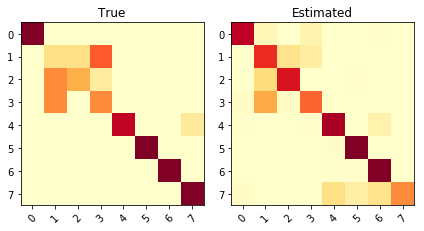

JS divergence: 0.1180	Norm Frobenius: 0.1340
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global       0.779         0.779      0.165276   0.211798       0.114955    0.108776
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.761785      0.761785
====  ======  ==========  ============


In [51]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(normalize(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred),norm='l1'), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


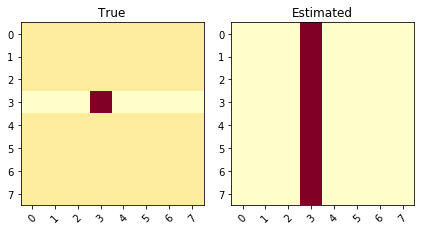

JS divergence: 0.6273	Norm Frobenius: 0.3094


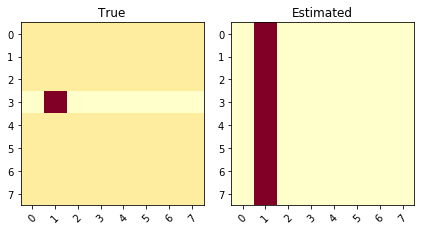

JS divergence: 0.6273	Norm Frobenius: 0.3094


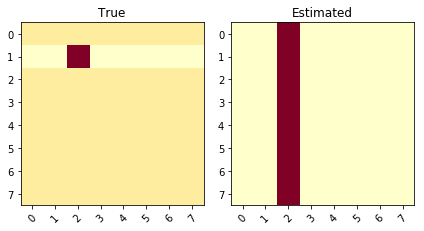

JS divergence: 0.6273	Norm Frobenius: 0.3094


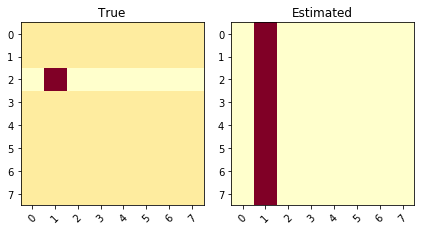

JS divergence: 0.6273	Norm Frobenius: 0.3094


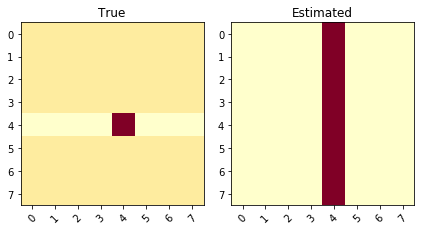

JS divergence: 0.6273	Norm Frobenius: 0.3094


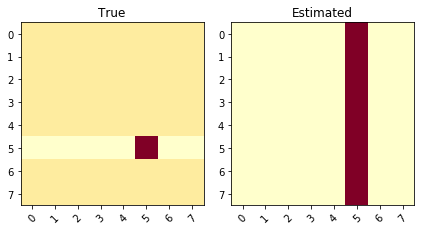

JS divergence: 0.6273	Norm Frobenius: 0.3094


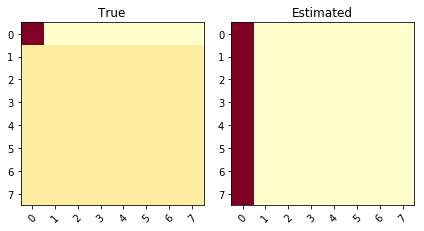

JS divergence: 0.6273	Norm Frobenius: 0.3094


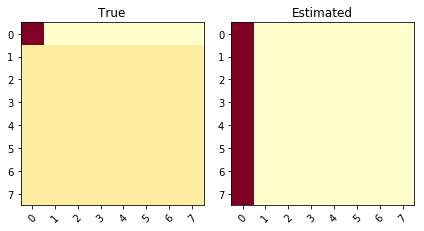

JS divergence: 0.6273	Norm Frobenius: 0.3094


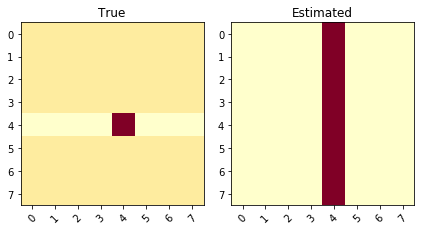

JS divergence: 0.6273	Norm Frobenius: 0.3094


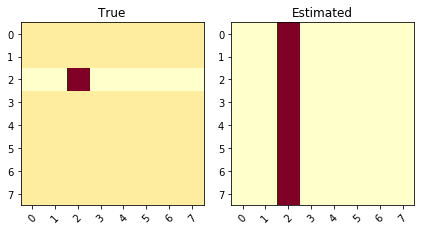

JS divergence: 0.6273	Norm Frobenius: 0.3094


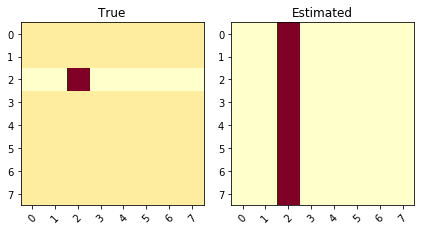

JS divergence: 0.6273	Norm Frobenius: 0.3094


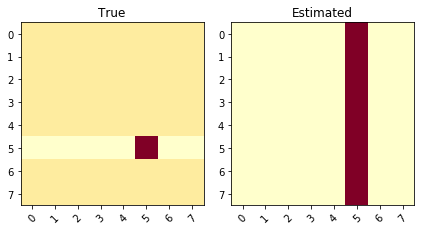

JS divergence: 0.6273	Norm Frobenius: 0.3094


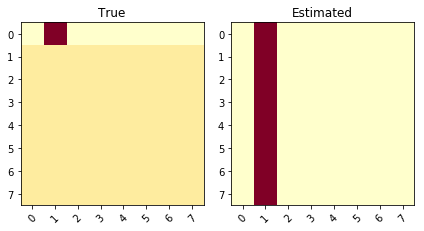

JS divergence: 0.6273	Norm Frobenius: 0.3094


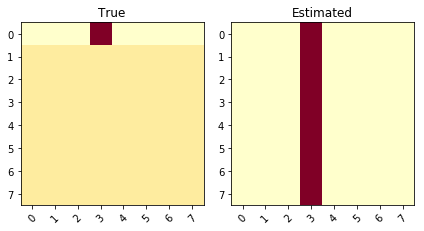

JS divergence: 0.6273	Norm Frobenius: 0.3094


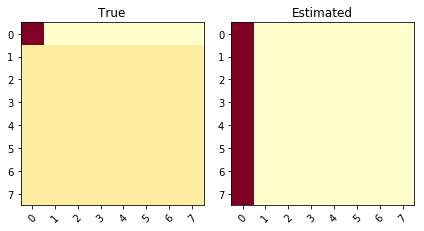

JS divergence: 0.6273	Norm Frobenius: 0.3094
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS
====  ======  ==========  ============  ============  =========  =============  ==========
   0  Global       0.125         0.125      0.309359   0.627296       0.309359    0.627296
====  ======  ==========  ============  ============  =========  =============  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.117845      0.117845
====  ======  ==========  ============


In [20]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


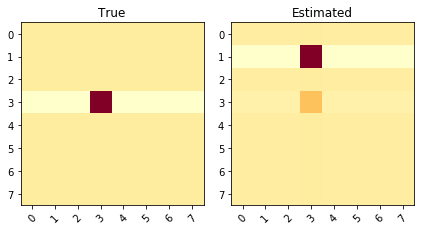

JS divergence: 0.0871	Norm Frobenius: 0.1150


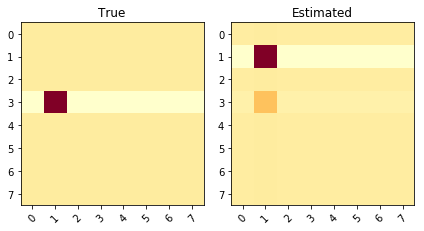

JS divergence: 0.0871	Norm Frobenius: 0.1150


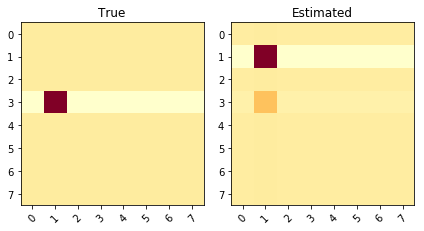

JS divergence: 0.0871	Norm Frobenius: 0.1150


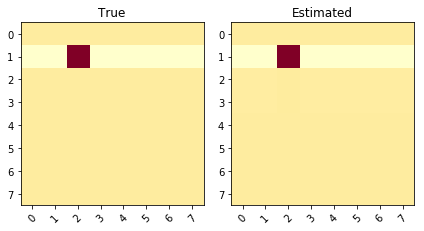

JS divergence: 0.0729	Norm Frobenius: 0.1041


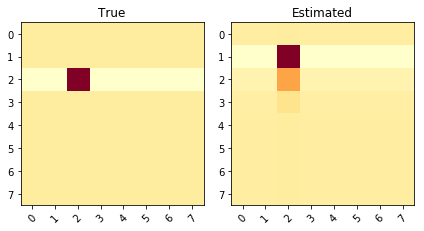

JS divergence: 0.0858	Norm Frobenius: 0.1141


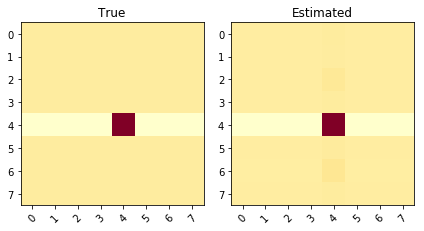

JS divergence: 0.0739	Norm Frobenius: 0.1049


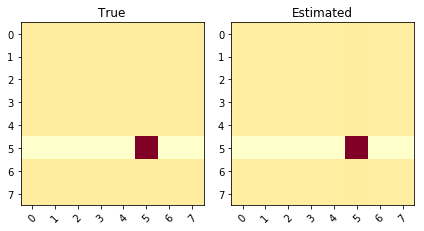

JS divergence: 0.0727	Norm Frobenius: 0.1039


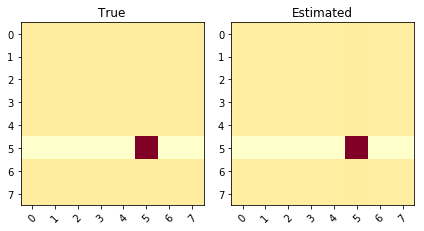

JS divergence: 0.0727	Norm Frobenius: 0.1039


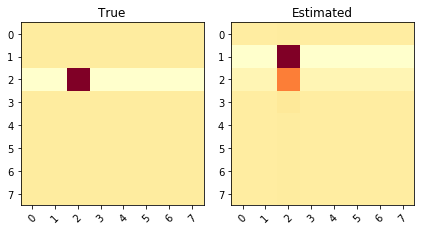

JS divergence: 0.0844	Norm Frobenius: 0.1130


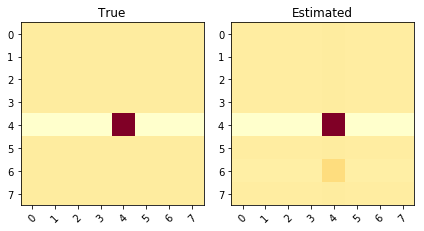

JS divergence: 0.0741	Norm Frobenius: 0.1051


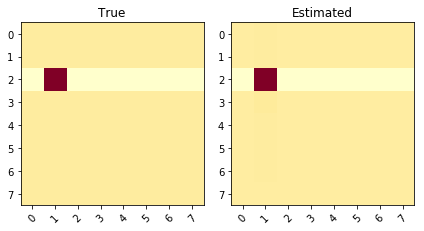

JS divergence: 0.0730	Norm Frobenius: 0.1041


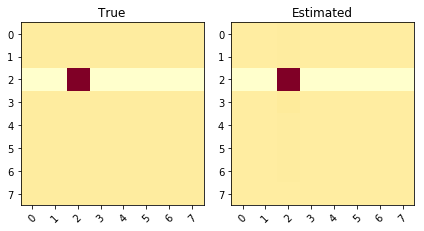

JS divergence: 0.0730	Norm Frobenius: 0.1041


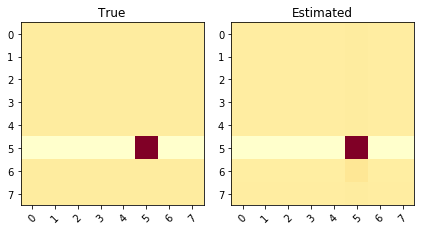

JS divergence: 0.0732	Norm Frobenius: 0.1043


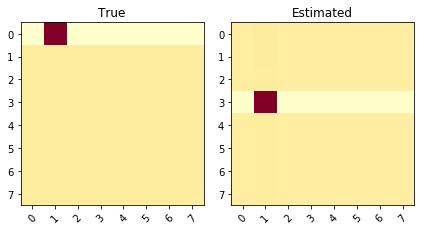

JS divergence: 0.0909	Norm Frobenius: 0.1175


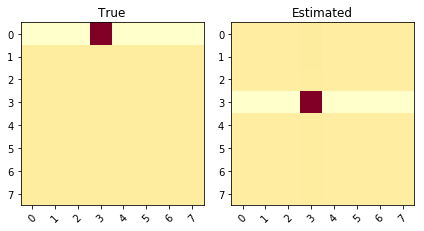

JS divergence: 0.0909	Norm Frobenius: 0.1175
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global       0.721         0.721      0.108127  0.0782216       0.108127   0.0782216            0             0
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                         1      

In [22]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


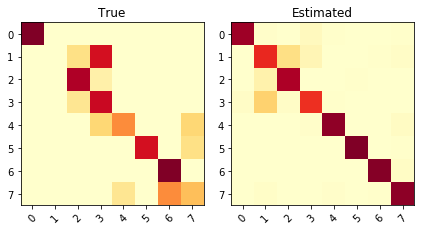

JS divergence: 0.2168	Norm Frobenius: 0.1849


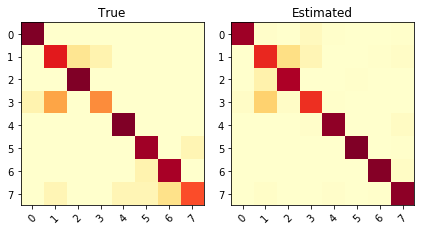

JS divergence: 0.0558	Norm Frobenius: 0.0636


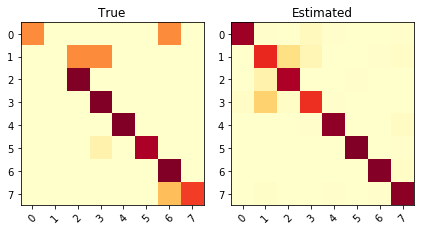

JS divergence: 0.1752	Norm Frobenius: 0.1574


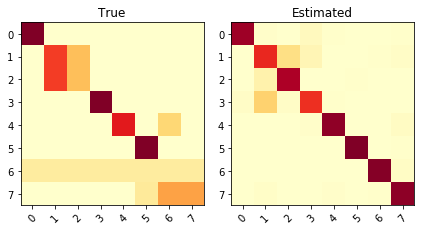

JS divergence: 0.2113	Norm Frobenius: 0.1854


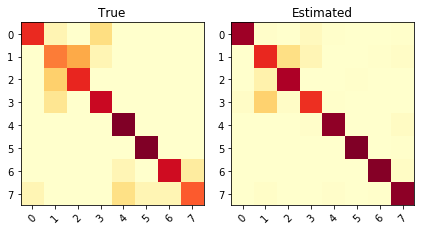

JS divergence: 0.0648	Norm Frobenius: 0.0831


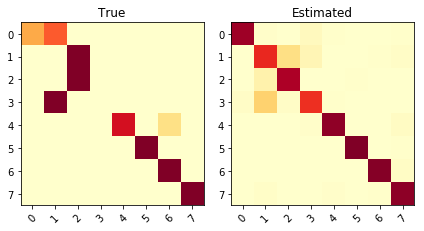

JS divergence: 0.2186	Norm Frobenius: 0.2101


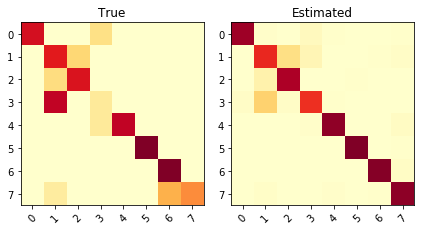

JS divergence: 0.1014	Norm Frobenius: 0.1303


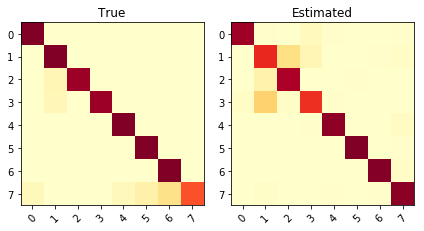

JS divergence: 0.0702	Norm Frobenius: 0.0811


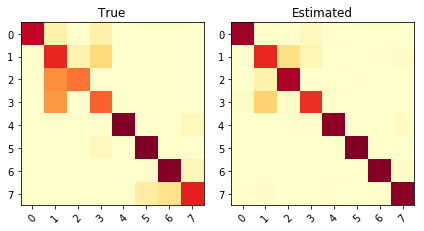

JS divergence: 0.0661	Norm Frobenius: 0.0868


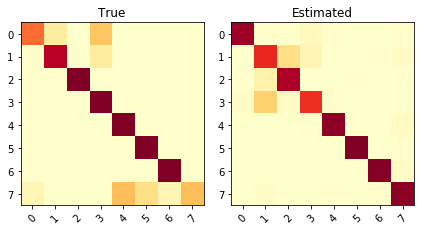

JS divergence: 0.1244	Norm Frobenius: 0.1257


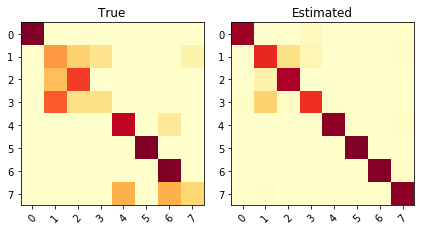

JS divergence: 0.1290	Norm Frobenius: 0.1454


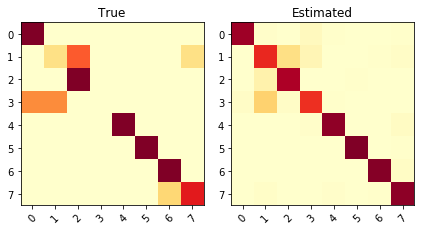

JS divergence: 0.1471	Norm Frobenius: 0.1441


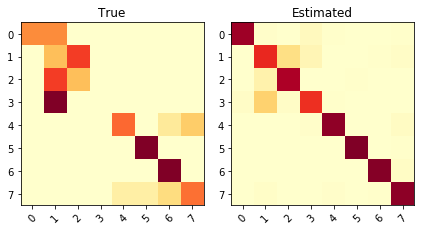

JS divergence: 0.2178	Norm Frobenius: 0.2106


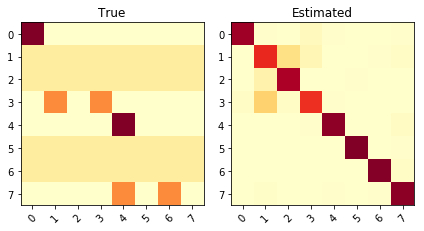

JS divergence: 0.4090	Norm Frobenius: 0.2553


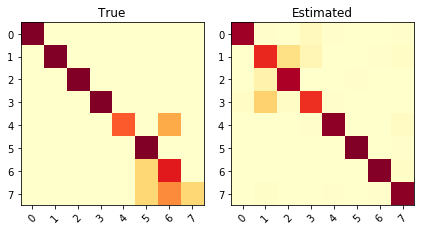

JS divergence: 0.1702	Norm Frobenius: 0.1535
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global       0.819         0.819      0.183261    0.22986       0.134758    0.135769     0.124083     0.0891245
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.773109      

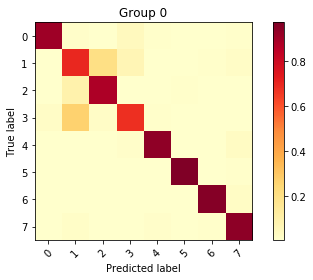

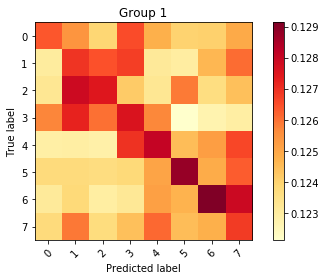

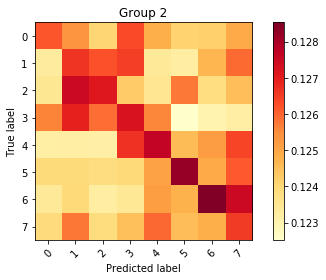

Inertia: 0.35733210286792355
A result
 ====  ========  ===========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups         Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ===========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.998503         58   0.463966     0.873884   0.143586      0.900472   0.855867      0.793771      0.793771
   1         1  0.000775631       0   2.07935      0.127649   2.05848      -0.0282535  0.00302745    0.580808      0.580808
   2         2  0.00072125        0   2.07937      0.127266   2.06148      -0.0291223  0.00258939    0.58165       0.58165
====  ========  ===========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  

In [60]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Global multiples runs***
Train


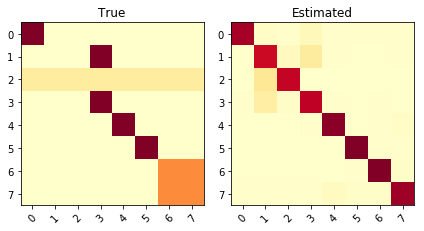

JS divergence: 0.2482	Norm Frobenius: 0.2100
Groups probabilities:  [0.84 0.09 0.08]


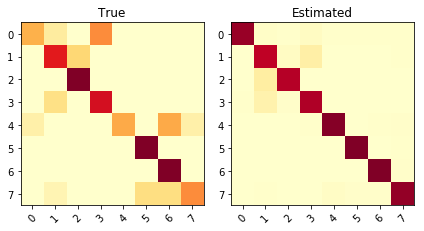

JS divergence: 0.1495	Norm Frobenius: 0.1473
Groups probabilities:  [1. 0. 0.]


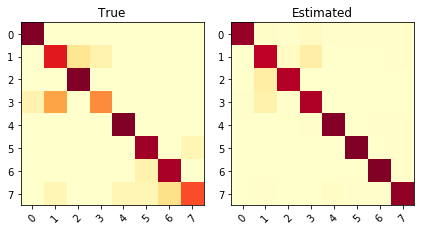

JS divergence: 0.0726	Norm Frobenius: 0.0855
Groups probabilities:  [1. 0. 0.]


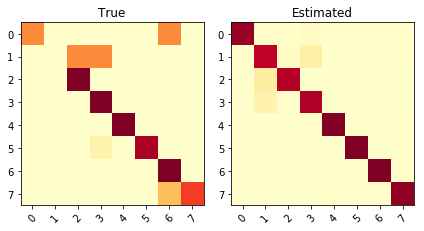

JS divergence: 0.1816	Norm Frobenius: 0.1649
Groups probabilities:  [1. 0. 0.]


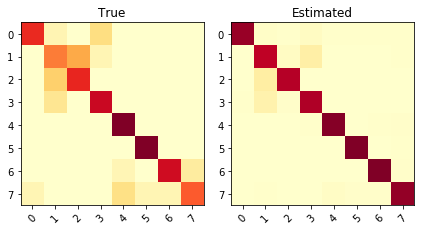

JS divergence: 0.0779	Norm Frobenius: 0.0931
Groups probabilities:  [1. 0. 0.]


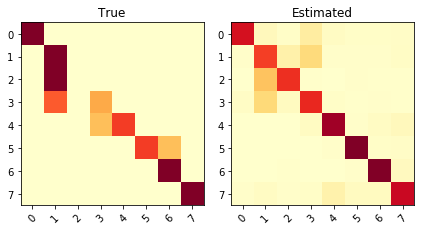

JS divergence: 0.2063	Norm Frobenius: 0.1674
Groups probabilities:  [0.21 0.41 0.38]


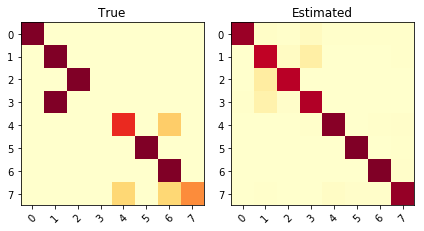

JS divergence: 0.1774	Norm Frobenius: 0.1803
Groups probabilities:  [0.98 0.01 0.01]


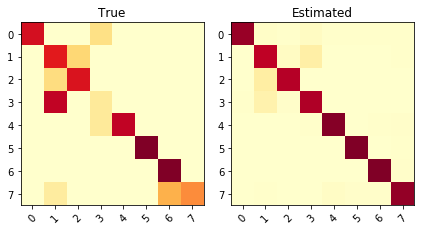

JS divergence: 0.1404	Norm Frobenius: 0.1586
Groups probabilities:  [1. 0. 0.]


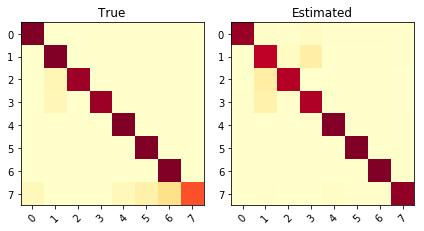

JS divergence: 0.0478	Norm Frobenius: 0.0566
Groups probabilities:  [1. 0. 0.]


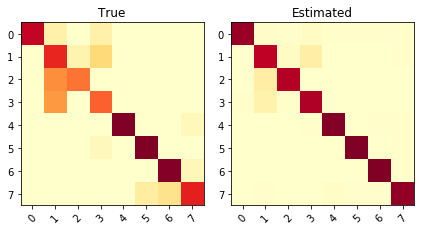

JS divergence: 0.0724	Norm Frobenius: 0.0974
Groups probabilities:  [1. 0. 0.]


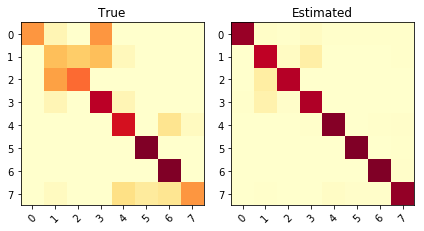

JS divergence: 0.1235	Norm Frobenius: 0.1422
Groups probabilities:  [1. 0. 0.]


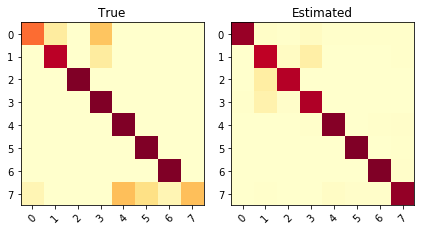

JS divergence: 0.0947	Norm Frobenius: 0.1099
Groups probabilities:  [1. 0. 0.]


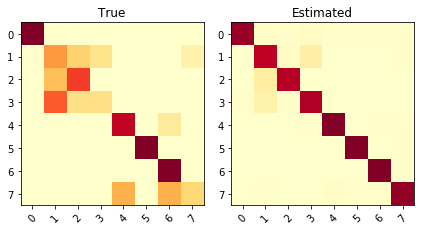

JS divergence: 0.1568	Norm Frobenius: 0.1678
Groups probabilities:  [1. 0. 0.]


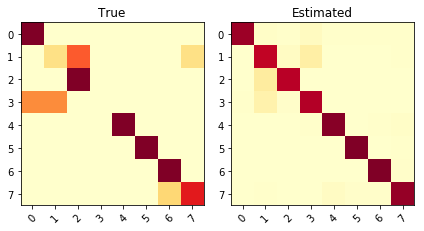

JS divergence: 0.2044	Norm Frobenius: 0.1792
Groups probabilities:  [0.96 0.02 0.02]


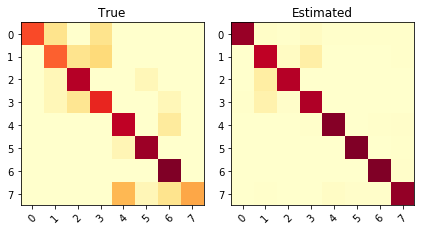

JS divergence: 0.0968	Norm Frobenius: 0.1060
Groups probabilities:  [1. 0. 0.]
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global        0.86          0.86      0.186072   0.228528       0.140439    0.141682      0.15522      0.116608
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
  

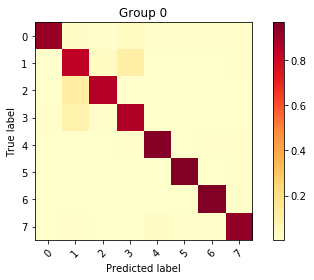

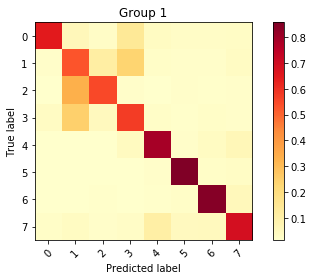

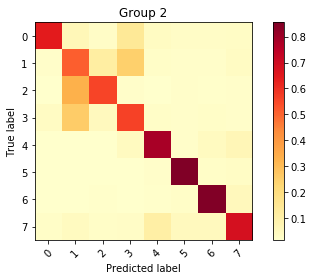

Inertia: 0.04303790349015241
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.66265       39   0.407681     0.910924  0.0946476       0.93292    0.898199    0.834175      0.834175
   1         1  0.169717      10   1.0635       0.685785  0.393377        0.735873   0.640897    0.835859      0.835859
   2         2  0.167633       9   1.07332      0.680533  0.40241         0.730422   0.634895    0.834175      0.834175
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [27]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
project confusion matrices